In [ ]:
# SPDX-FileCopyrightText: Copyright (c) 2023-2024 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: Apache-2.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Try out the NVIDIA Multimodal PDF Data Extraction Blueprint!

Welcome!

PDFSpeak is an innovative approach to interacting with complex PDF documents using NVIDIA's cutting-edge AI technologies through speech, vision, and text. In this notebook, we will walk through the components of the PDFSpeak solution.


**Important Notes**: 
1. In order to run this notebook, you need to visit NGC and get a key.
2. **Because this solution uses a 3xA100 cluster, it can get expensive to leave on for a long time.**
3. This notebook is based on the [NVIDIA Multimodal PDF Data Extraction Blueprint Notebook](https://github.com/NVIDIA/nv-ingest/blob/main/deploy/pdf-blueprint.ipynb).

# Introduction

It is a cohesive solution enabling you to talk to your PDFs with a familiar chat UI webapp that allows you to upload your own PDF. You can then ask your queries aloud, which are then converted to prompts by [RIVA ASR pipeline](https://docs.nvidia.com/deeplearning/riva/user-guide/docs/asr/asr-overview.html), a GPU-accelerated compute pipeline with optimized performance and accuracy. After this step, the prompt, along with the the PDF, reaches NV-Ingest. 

[NVIDIA-Ingest](https://github.com/NVIDIA/nv-ingest/tree/main) is a scalable, performance-oriented document content and metadata extraction microservice. It enables parallelization of the process of splitting documents into pages where contents are classified (as tables, charts, images, text), extracted into discrete content, and further contextualized via optical character recognition (OCR) into a well defined JSON schema. From there, NVIDIA Ingest can optionally manage computation of embeddings for the extracted content, and also optionally manage storing into a vector database [Milvus](https://milvus.io/).

The textual response from NV-Ingest then goes to [RIVA TTS pipeline](https://docs.nvidia.com/deeplearning/riva/user-guide/docs/asr/asr-overview.html), a two-stage pipeline that generates a mel-spectrogram using the first model, and then generates speech using the second model. This speech response is further processed by the PDFSpeak webapp to be played back to you.


# Architecture

This blueprint is comprised of multiple pieces that come together to form a powerful multi-modal RAG solution

![arch](pdfspeak_architecture.png)

# Prerequisites

### Hardware

| GPU | Family | Memory | # of GPUs (min.) |
| ------ | ------ | ------ | ------ |
| A100 | SXM or PCIe | 80GB | 3 |

### Software

- Linux operating systems (Ubuntu 22.04 or later recommended)
- [Docker](https://docs.docker.com/engine/install/)
- [Docker Compose](https://docs.docker.com/compose/install/)
- [CUDA Toolkit](https://developer.nvidia.com/cuda-downloads) (NVIDIA Driver >= `550`, CUDA >= `12.6`)
- [NVIDIA Container Toolkit](https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/latest/install-guide.html)



# Running PDFSpeak

## Sanity Checks

Run the following commands, if either of them fail then please skip to the "Step 0" section and follow the directions there.

1.Run the following command to check if all components of `NV-Ingest` are up and healthy:

In [33]:
!curl -X 'GET' 'http://172.17.0.1:7670/v1/health/ready'

{"ready":true}

2. To access the UI. Go to https://172.17.0.1:3002. Click on Advanced and Proceed (Unsafe) option [This warning can be safely ignored as it shows up if a self signed certificate is used on X-platform CORS]. 

## A Closer Look at PDFSpeak

The next section is entirely optional, but will allow you to interact with different components of PDFSpeak directly to understand how the application is working behind the scenes. We will include 

### Interacting with NV-Ingest
[NVIDIA-Ingest](https://github.com/NVIDIA/nv-ingest) is a scalable, performance-oriented document content and metadata extraction microservice. Including support for parsing PDFs, Word and PowerPoint documents, it uses specialized NVIDIA NIM microservices to find, contextualize, and extract text, tables, charts and images for use in downstream generative applications. 

`nv-ingest` is a key component of PDFSpeak.There are 2 ways to interact with `nv-ingest`,a python client and a CLI. We will focus on using the Python Client API.

### Using the python client 

Each ingest job will include a set of stages. These stages define and configure the operations that will be performed during ingestion of the specified input files.

- `extract` : Performs multimodal extractions from a document, including text, images, and tables.
- `split` : Chunk the text into smaller chunks, useful for storing in a vector database for retrieval applications.
- `dedup` : Identifies duplicate images in document that can be filtered to remove data redundancy.
- `filter` : Filters out images that are likely not useful using some heuristics, including size and aspect ratio.
- `embed` : Pass the text or table extractions through `"nvidia/nv-embedqa-e5-v5` NIM to obtain its embeddings.
- `store` : Save the extracted tables or images to MinIO, Milvus's storage system.

In [34]:
from nv_ingest_client.client import Ingestor

# Load a sample PDF to demonstrate NV-Ingest usage.
ingestor = ( 
    Ingestor(message_client_hostname="172.17.0.1", message_client_port=7670)
    .files("./woods_frost.pdf") # can be a list of files, or contain wildcards i.e. /some/path/*.pdf
    .extract(
        extract_text=True,
        extract_tables=True,
        extract_charts=True,
        extract_images=True,
    ).split(
        split_by="word",
        split_length=300,
        split_overlap=10,
        max_character_length=5000,
        sentence_window_size=0,
    ).embed( # whether to compute embeddings
        text=True, tables=True
    ) 
)

# Result is a List[List[Dict]] - Each outer list Item [] is a file and each inner list Item [][] is an element in that file
generated_metadata = ingestor.ingest()

In [35]:
from nv_ingest_client.util.process_json_files import ingest_json_results_to_blob

# generated_metadata is the result of a batch of submitted files. We sample the first file metadata here for demonstration purposes.
ingest_json_results_to_blob(generated_metadata[0])

"Stopping by Woods on a Snowy Evening, By Robert Frost\r\nFigure 1: Snowy Woods\r\nWhose woods these are I think I know. His house is in the village though; He will not see me \r\nstopping here; To watch his woods fill up with snow. \r\nMy little horse must think it queer; To stop without a farmhouse near; Between the woods and \r\nfrozen lake; The darkest evening of the year. \r\nHe gives his harness bells a shake; To ask if there is some mistake. The only other sound’s the \r\nsweep; Of easy wind and downy flake. \r\nThe woods are lovely, dark and deep, But I have promises to keep, And miles to go before I \r\nsleep, And miles to go before I sleep.\r\nFrost’s Collections\r\nFigure 2: Robert Frost # Collection Year 1 A Boy's Will 1913 2 North of Boston 1914 3 Mountain Interval 1916 4 New Hampshire 1923 5 West Running Brook 1928 6 A Further Range 1937 7 A Witness Tree 1942 8 In the Clearing 1962 9 Steeple Bush 1947\r\n10 An Afterwordunknown\nimage_caption:[]\nimage_caption:[]\n# Collec

### Explore the Outputs

Let's explore elements of the NV-Ingest output. When data flows through an NV-Ingest pipeline, a number of extractions and transformations are performed. As the data is enriched, it is stored in rich metadata hierarchy. In the end, there will be a list of dictionaries, each of which represents a extracted type of information. The most common elements to extract from a dictionary in this hierarchy are the extracted content and the text representation of this content. The next few cells will demonstrate interacting with the metadata, pulling out these elements, and visualizing them. Note, when there is a -1 value present, this represents non-applicable positional resolution. Positive numbers represent valid positional data.

For a more complete description of metadata elements, view the data dictionary.

https://github.com/NVIDIA/nv-ingest/blob/main/docs/content-metadata.md

In [36]:
def redact_metadata_helper(metadata: dict) -> dict:
    """A simple helper function to redact `metadata["content"]` and metadata["embedding"]' to improve readability."""
    
    text_metadata_redact = metadata.copy()
    text_metadata_redact["metadata"]["content"] = "<---Redacted for readability--->"
    text_metadata_redact["metadata"]["embedding"] = "<---Redacted for readability--->"
    
    return text_metadata_redact

### Explore Output - Text

This cell depicts the full metadata hierarchy for a text extraction with redacted content to ease readability. Notice the following sections are populated with information:

- `content` - The raw extracted content, text in this case - this section will always be populated with a successful job.
- `content_metadata` - Describes the type of extraction and its position in the broader document - this section will always be populated with a successful job.
- `source_metadata` - Describes the source document that is the basis of the ingest job.
- `text_metadata` - Contain information about the text extraction, including detected language, among others - this section will only exist when `metadata['content_metadata']['document_type'] == 'text'`

In [37]:
redacted_text_metadata = redact_metadata_helper(generated_metadata[0][0])  # First file, first element of elements found within file [0][0]. There are 9 total
redacted_text_metadata

{'document_type': 'text',
 'metadata': {'chart_metadata': None,
  'content': '<---Redacted for readability--->',
  'content_metadata': {'description': 'Unstructured text from PDF document.',
   'hierarchy': {'block': -1,
    'line': -1,
    'nearby_objects': {'images': {'bbox': [], 'content': []},
     'structured': {'bbox': [], 'content': []},
     'text': {'bbox': [], 'content': []}},
    'page': -1,
    'page_count': 2,
    'span': -1},
   'page_number': -1,
   'subtype': '',
   'type': 'text'},
  'debug_metadata': None,
  'embedding': '<---Redacted for readability--->',
  'error_metadata': None,
  'image_metadata': None,
  'info_message_metadata': None,
  'raise_on_failure': False,
  'source_metadata': {'access_level': 1,
   'collection_id': '',
   'date_created': '2024-04-30T18:02:30',
   'last_modified': '2024-04-30T18:02:32',
   'partition_id': -1,
   'source_id': './woods_frost.pdf',
   'source_location': '',
   'source_name': './woods_frost.pdf',
   'source_type': 'PDF',
   's

### Explore Output - Tables

This cell depicts the full metadata hierarchy for a table extraction with redacted content to ease readability. Notice the following sections are populated with information:

- `content` - The raw extracted content, a base64 encoded image of the extracted table in this case - this section will always be populated with a successful job.
- `content_metadata` - Describes the type of extraction and its position in the broader document - this section will always be populated with a successful job.
- `source_metadata` - Describes the source and storage path of an extracted table in an S3 compliant object store.
- `table_metadata` - Contains the text representation of the table, positional data, and other useful elements - this section will only exist when `metadata['content_metadata']['document_type'] == 'structured'`.

Note, `table_metadata` will store chart and table extractions. The are distringuished by `metadata['content_metadata']['subtype']`

In [38]:
redacted_table_metadata = redact_metadata_helper(generated_metadata[0][2])  # First file, third element within file [0][2]. There are 9 total
redacted_table_metadata

{'document_type': 'image',
 'metadata': {'chart_metadata': None,
  'content': '<---Redacted for readability--->',
  'content_metadata': {'description': 'Image extracted from PDF document.',
   'hierarchy': {'block': -1,
    'line': -1,
    'nearby_objects': {'images': {'bbox': [], 'content': []},
     'structured': {'bbox': [], 'content': []},
     'text': {'bbox': [], 'content': []}},
    'page': 0,
    'page_count': 2,
    'span': -1},
   'page_number': 0,
   'subtype': '',
   'type': 'image'},
  'debug_metadata': None,
  'embedding': '<---Redacted for readability--->',
  'error_metadata': None,
  'image_metadata': {'caption': '',
   'height': 597,
   'image_location': [72.0,
    121.49464416503906,
    201.7196044921875,
    315.69464111328125],
   'image_location_max_dimensions': [612.0, 792.0],
   'image_type': 'PNG',
   'structured_image_type': 'image_type_1',
   'text': '',
   'uploaded_image_url': '',
   'width': 0},
  'info_message_metadata': None,
  'raise_on_failure': False,

# Building an E2E reranking and retreival pipeline

Reranking is crucial for achieving high accuracy and efficiency in retrieval pipelines. It plays a vital role, particularly when the pipeline incorporates citations from diverse datastores, where each datastore may employ its own unique similarity scoring algorithm. Reranking serves two primary purposes:

1. Improving accuracy for individual citations within each datastore.
2. Integrating results from multiple datastores to provide a cohesive and relevant set of citations.

We'll be using a couple different NIMs for this pipeline. These are a combination of models running locally and hosted on [build.nvidia.com]. However, all of these can be self hosted!
1. `nv-embedqa-e5-v5`: this will serve as our embedding model. `nv-ingest` will use this in the `VdbUploadTask`
2. `nv-rerankqa-mistral-4b-v3`: this will be our reranking model
3. `llama-3.1-nemotron-70b-instruct`: NVIDIA's new SOTA model for our LLM

For this example, lets use the table in the `woods_frost.pdf`. For reference, here it is 

| # | Collection | Year |
|---|------------|------|
| 1 | A Boy's Will | 1913 |
| 2 | North of Boston | 1914 |
| 3 | Mountain Interval | 1916 |
| 4 | New Hampshire | 1923 |
| 5 | West Running Brook | 1928 |
| 6 | A Further Range | 1937 |
| 7 | A Witness Tree | 1942 |
| 8 | In the Clearing | 1962 |
| 9 | Steeple Bush | 1947 |
| 10 | An Afterword | unknown |

This table lists various poetry collections by Robert Frost, along with their publication years. Note that the year for "An Afterword" is listed as unknown.

Note: this demo is hosted live on  [build.nvidia.com](https://build.nvidia.com/nvidia/multimodal-pdf-data-extraction-for-enterprise-rag)

In [39]:
from openai import OpenAI

client = OpenAI(
  base_url = "https://integrate.api.nvidia.com/v1"
)

completion = client.chat.completions.create(
  model="nvidia/llama-3.1-nemotron-70b-instruct",
  messages=[{"role":"user","content":"What are Robert Frosts poetry collections. Provide the name and year."}],
  temperature=0.5,
  top_p=1,
  max_tokens=1024,
  stream=True
)

for chunk in completion:
  if chunk.choices[0].delta.content is not None:
    print(chunk.choices[0].delta.content, end="")

Here are the poetry collections of Robert Frost, listed in chronological order by publication year:

's Will** (1913)
 of Boston** (1914)
 Interval** (1924)
** (1923) *won the Pulitzer Prize for Poetry in 1924*
 Poems** (1930)
 Range** (1936)
 Range (including Collected Poems)** (1937) *updated edition*
** (1942)tness Tree
 and Other Poems** (1943)
 **Steeple Bush** (1947)
. **Complete Poems of Robert Frost, 1949** (1949)
 Clearing** (1962)

 Collections:**

** (1979) *edited by Edward Connery Lathem*
lected Poems, Prose, and Plays** (1995) *edited by Richard Poirier and Mark Richardson*
 Frost** (2006) *edited by Robert Faggen*

## Testing with no pipeline

Lets see what our LLM knows about Robert Frost's poetry

In [40]:
from openai import OpenAI

client = OpenAI(
  base_url = "https://integrate.api.nvidia.com/v1"
)

completion = client.chat.completions.create(
  model="nvidia/llama-3.1-nemotron-70b-instruct",
  messages=[{"role":"user","content":"What are Robert Frosts poetry collections. Provide the name and year."}],
  temperature=0.5,
  top_p=1,
  max_tokens=1024,
  stream=True
)

for chunk in completion:
  if chunk.choices[0].delta.content is not None:
    print(chunk.choices[0].delta.content, end="")

Here are the poetry collections of Robert Frost, listed in chronological order by publication year:

** (1913)y's Will
 (1914)rth of Boston**
4) **Mountain Interval** (192
 *won the Pulitzer Prize for Poetry in 1924*
5. **Collected Poems** (1930)
6. **Further Range** (1936)
 **A Further Range (including Collected Poems)** (1937) *updated edition*
 Tree** (1942)
 and Other Poems** (1943)
Steeple Bush** (1947)
Complete Poems of Robert Frost, 1949** (1949)
1962)*In the Clearing** (

**Posthumous Collections:**

 **The Poetry of Robert Frost** (1979) *edited by Edward Connery Lathem*
Robert Frost: Collected Poems, Prose, and Plays** (1995) *edited by Richard Poirier and Mark Richardson*
 Robert Frost** (2006) *edited by Robert Faggen*

## With pipeline

Our model got some of them but also included some selected works that we were not looking for. Lets see if we can improve this response

### Pipeline section 1: Extraction

We first extract the document metadata using nv-ingest.

In [41]:
from nv_ingest_client.client import Ingestor
from nv_ingest_client.util.file_processing.extract import extract_file_content

file_content, file_type = extract_file_content("./woods_frost.pdf")

# Load a sample PDF to demonstrate NV-Ingest usage.
ingestor = (
    Ingestor(message_client_hostname="172.17.0.1", message_client_port=7670)
    .files("./woods_frost.pdf") # can be a list of files, or contain wildcards i.e. /some/path/*.pdf
    .extract(
        extract_text=True,
        extract_tables=True,
        extract_charts=True,
        extract_images=True,
    ).split(
        split_by="word",
        split_length=300,
        split_overlap=10,
        max_character_length=5000,
        sentence_window_size=0,
    ).embed( # whether to compute embeddings
        text=True, tables=True
    )
)

generated_metadata = ingestor.ingest()

### Pipeline section 2: Visualize metadata 

Below we provide some helper functions that can be used to analyze the metadata

In [42]:
from collections import Counter
from typing import List, Dict, Any
from base64 import b64decode
from IPython.display import display, Image

def count_metadata_types(metadata: List[Dict[str, Any]]) -> Dict[str, int]:
    """
    Count the number of each metadata type in the generated metadata.
    """
    return dict(Counter(item['document_type'] for item in metadata))

def analyze_text_metadata(metadata: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Analyze text metadata and return key information.
    """
    text_items = [item for item in metadata if item['document_type'] == 'text']
    if not text_items:
        return {"error": "No text metadata found"}
    
    text_item = text_items[0]['metadata']
    return {
        "language": text_item['text_metadata']['language'],
        "page_count": text_item['content_metadata']['hierarchy']['page_count'],
        "source_name": text_item['source_metadata']['source_name'],
        "content_preview": text_item['content'][:200] + "..."  # First 200 characters
    }

def analyze_table_metadata(metadata: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Analyze table metadata and return key information for each table.
    """
    table_items = [item['metadata'] for item in metadata 
                   if item['document_type'] == 'structured' 
                   and item['metadata']['content_metadata']['subtype'] == 'table']
    
    return [{
        "content_preview": table['table_metadata']['table_content'][:100] + "...",
        "location": table['table_metadata']['table_location'],
        "page_number": table['content_metadata']['page_number']
    } for table in table_items]

def analyze_chart_metadata(metadata: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Analyze chart metadata and return key information for each chart.
    """
    chart_items = [item['metadata'] for item in metadata 
                   if item['document_type'] == 'structured' 
                   and item['metadata']['content_metadata']['subtype'] == 'chart']
    
    return [{
        "content_preview": chart['table_metadata']['table_content'][:100] + "...",
        "location": chart['table_metadata']['table_location'],
        "page_number": chart['content_metadata']['page_number']
    } for chart in chart_items]

def analyze_image_metadata(metadata: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Analyze image metadata and return key information for each image.
    """
    image_items = [item['metadata'] for item in metadata if item['document_type'] == 'image']
    
    return [{
        "image_type": img['image_metadata']['image_type'],
        "dimensions": f"{img['image_metadata']['width']}x{img['image_metadata']['height']}",
        "location": img['image_metadata']['image_location'],
        "page_number": img['content_metadata']['page_number']
    } for img in image_items]

def display_image(metadata: List[Dict[str, Any]], index: int = 0):
    """
    Display an image from the metadata at the specified index.
    """
    image_items = [item for item in metadata if item['document_type'] == 'image']
    if index < 0 or index >= len(image_items):
        print(f"Invalid index. There are {len(image_items)} images.")
        return
    
    image_data = b64decode(image_items[index]['metadata']['content'])
    display(Image(image_data))

def comprehensive_metadata_analysis(metadata: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Perform a comprehensive analysis of the metadata and return a summary.
    """
    return {
        "type_counts": count_metadata_types(metadata),
        "text_analysis": analyze_text_metadata(metadata),
        "table_analysis": analyze_table_metadata(metadata),
        "chart_analysis": analyze_chart_metadata(metadata),
        "image_analysis": analyze_image_metadata(metadata)
    }

def print_metadata_summary(analysis: Dict[str, Any]):
    """
    Print a formatted summary of the metadata analysis.
    """
    print("NV-Ingest Metadata Analysis Summary")
    print("===================================")
    
    print("\nMetadata Type Counts:")
    for doc_type, count in analysis['type_counts'].items():
        print(f"  {doc_type}: {count}")
    
    print("\nText Analysis:")
    text_analysis = analysis['text_analysis']
    print(f"  Language: {text_analysis['language']}")
    print(f"  Page Count: {text_analysis['page_count']}")
    print(f"  Source Name: {text_analysis['source_name']}")
    print(f"  Content Preview: {text_analysis['content_preview']}")
    
    print("\nTable Analysis:")
    for i, table in enumerate(analysis['table_analysis'], 1):
        print(f"  Table {i}:")
        print(f"    Content Preview: {table['content_preview']}")
        print(f"    Location: {table['location']}")
        print(f"    Page Number: {table['page_number']}")
    
    print("\nChart Analysis:")
    for i, chart in enumerate(analysis['chart_analysis'], 1):
        print(f"  Chart {i}:")
        print(f"    Content Preview: {chart['content_preview']}")
        print(f"    Location: {chart['location']}")
        print(f"    Page Number: {chart['page_number']}")
    
    print("\nImage Analysis:")
    for i, image in enumerate(analysis['image_analysis'], 1):
        print(f"  Image {i}:")
        print(f"    Type: {image['image_type']}")
        print(f"    Dimensions: {image['dimensions']}")
        print(f"    Location: {image['location']}")
        print(f"    Page Number: {image['page_number']}")

NV-Ingest Metadata Analysis Summary

Metadata Type Counts:
  text: 1
  structured: 1
  image: 2

Text Analysis:
  Language: en
  Page Count: 2
  Source Name: ./woods_frost.pdf
  Content Preview: Stopping by Woods on a Snowy Evening, By Robert Frost
Figure 1: Snowy Woods
Whose woods these are I think I know. His house is in the village though; He will not see me 
stopping here; To watch his...

Table Analysis:
  Table 1:
    Content Preview: # Collection Year 1 A Boy's Will 1913 2 North of Boston 1914 3 Mountain Interval 1916 4 New Hampshir...
    Location: [51.916799999999995, 134.6058, 565.248, 1051.0884999999998]
    Page Number: 1

Chart Analysis:

Image Analysis:
  Image 1:
    Type: PNG
    Dimensions: 0x563
    Location: [72.0, 534.174560546875, 299.99114990234375, 700.8745727539062]
    Page Number: 0
  Image 2:
    Type: PNG
    Dimensions: 0x597
    Location: [72.0, 121.49464416503906, 201.7196044921875, 315.69464111328125]
    Page Number: 0


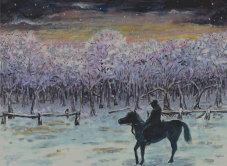

In [43]:
analysis = comprehensive_metadata_analysis(generated_metadata[0])  # One analyze first file result
print_metadata_summary(analysis)

# To display an image:
display_image(generated_metadata[0], 0)  # Display the first image

### Pipeline section 3: Embedding, Storage, and Saving to a Vector DB

We now create our Milvus collection and bulk upload our nv-ingest `generated_metadata` to the collection from Minio.

In [44]:
from nv_ingest_client.util.milvus import create_nvingest_collection, write_to_nvingest_collection

sparse = False
COLLECTION_NAME="nv_ingest_collection_test"

# Create the Milvus collection
schema = create_nvingest_collection(COLLECTION_NAME, f"http://milvus:19530", sparse=sparse, dense_dim=1024)

In [45]:
# Index the nv-ingest generated_metadata to the Milvus collection
write_to_nvingest_collection(generated_metadata, COLLECTION_NAME, sparse=sparse, milvus_uri=f"http://milvus:19530", minio_endpoint="minio:9000")

Wrote data to: [['b198226d-8980-4d5f-b282-51025f38818c/1.parquet']]
Start time: 2025-03-05 00:39:30
Imported row count: 2
Bulk nv_ingest_collection_test upload took 16.03606677055359 s


### Pipeline section 4: Connect to MilvusDB and the embedding model to start querying

In [46]:
import os
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings, NVIDIARerank, ChatNVIDIA
from langchain_milvus import Milvus


embedding = NVIDIAEmbeddings(model="nvidia/nv-embedqa-e5-v5")

reranker = NVIDIARerank(model="nvidia/nv-rerankqa-mistral-4b-v3")

llm = ChatNVIDIA(model="nvidia/llama-3.1-nemotron-70b-instruct")


vectorstore = Milvus(
    embedding_function=embedding,
    collection_name=COLLECTION_NAME,
    primary_field = "pk",
    vector_field = "vector",
    text_field="text",
    connection_args={"uri": "http://172.17.0.1:19530"},
)
retriever = vectorstore.as_retriever()

In [23]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

template = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Keep the answer concise."
    "\n\n"
    "{context}"
    "Question: {question}"
)

prompt = PromptTemplate.from_template(template)

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)
resp=rag_chain.invoke("What are Robert Frosts poetry collections. Provide the name and year.?")

print(resp)

Based on the retrieved context, here are Robert Frost's poetry collections with their corresponding years:

1. **A Boy's Will** - 1913
2. **North of Boston** - 1914
3. **Mountain Interval** - 1916
4. **New Hampshire** - 1923
5. **West Running Brook** - 1928
6. **A Further Range** - 1937
7. **A Witness Tree** - 1942
8. **Steeple Bush** - 1947
9. **In the Clearing** - 1962
10. **An Afterword** - **Unknown** (year not specified)


### Interacting with NVIDIA Riva

[NVIDIA® Riva](https://www.nvidia.com/en-us/ai-data-science/products/riva/) is a set of GPU-accelerated multilingual speech and translation microservices for building fully customizable, real-time conversational AI pipelines. Riva includes automatic speech recognition (ASR), text-to-speech (TTS), and neural machine translation (NMT) and is deployable in all clouds, in data centers, at the edge, and on embedded devices.

NVIDIA Riva is another key component of PDFSpeak, enabling the ASR and TTS components used in the application. Let's check that the RIVA components are ready-to-use. You will be able to interact with the Riva components directly in the PDFSpeak application launched on port 3002.

#### TTS

In [49]:
!curl -X 'GET' 'http://fastpitch-tts:9001/v1/health/ready'

{"status":"ready"}

In [50]:
!python3 riva-examples/scripts/tts/talk.py --server fastpitch-tts:50052 --text "Welcome to Nvidia GTC 2025" --language-code en-US --output output.wav 

Generating audio for request...
Time spent: 0.195s


#### ASR

In [51]:
!curl -X 'GET' 'http://parakeet-asr:9099/v1/health/ready'

{"status":"ready"}

In [52]:
!python3 riva-examples/scripts/asr/transcribe_file.py --server parakeet-asr:50051 --input-file output.wav --language-code en-US 

## welcome to nvidia gtc twenty twenty five 


## Putting It All Together

Now that we have reviewed the NV-Ingest components and Riva components, let's start putting it all together by converting the text answer of the query to speech using TTS.

> [NOTE] If you have trouble playing the `.wav` file generated above, try downloading it and playing it on your personal machine.

In [53]:
from riva.client import Auth, SpeechSynthesisService
import wave
import os

def get_riva_tts_service():
    RIVA_URI = "fastpitch-hifigan-tts:50052"
    auth = Auth(uri=RIVA_URI)
    tts_service = SpeechSynthesisService(auth)
    os.makedirs("audio_outputs", exist_ok=True)
    return tts_service

def generate_tts(text, filename="assistant_output.wav"):
    try:
        print("[INFO] Generate TTS Start")
        tts_service = get_riva_tts_service()
        response = tts_service.synthesize(
            text=text,
            voice_name="English-US.Female-1",
            language_code="en-US",
            sample_rate_hz=44100
        )
        
        audio_path = f"audio_outputs/{filename}"
        

        with wave.open(audio_path, 'wb') as wav_file:
            wav_file.setnchannels(1)  
            wav_file.setsampwidth(2)  
            wav_file.setframerate(44100)
            

            wav_file.writeframes(response.audio)
        print("[INFO]  Generate TTS End: ",audio_path)
            
        return audio_path
        
    except Exception as e:
        print(f"TTS Generation Error: {str(e)}")
        return None

In [54]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

template = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Keep the answer concise."
    "\n\n"
    "{context}"
    "Question: {question}"
)

prompt = PromptTemplate.from_template(template)

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)
resp=rag_chain.invoke("What does Figure 1 show?")
print(resp)
generate_tts(resp)

Based on the retrieved context, Figure 1 is described as:
**Figure 1: Snowy Woods** 

Therefore, the answer is: **Snowy Woods** (presumably an image, but the actual image content is not provided in the text).
[INFO] Generate TTS Start
[INFO]  Generate TTS End:  audio_outputs/assistant_output.wav


'audio_outputs/assistant_output.wav'

By taking the pipeline that we've generated above, scaling it, and combining it with a custom user interface and ASR (which is run within the UI components), you can generate custom application demo like the one shown below.

## Interacting with PDFSpeak

To access the UI, go to [https://localhost:3002/]. Click on Advanced and Proceed (Unsafe) option [This warning can be safely ignored as it shows up if a self signed certificate is used on X-platform CORS]. 

# <font color="Purple">Time to get speaking!</font>